In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
df = pd.read_csv("../Resources/Clean Data/combined_OvHo_df.csv")
df

,State,Overall Homeless,Year
0,AL,3304,2023
1,AR,2609,2023
2,AZ,14237,2023
3,CA,181399,2023
4,CO,14439,2023
...,...,...,...
811,VT,1035,2007
812,WA,23379,2007
813,WI,5648,2007
814,WV,2409,2007


In [7]:
agg_data_yearly = df.groupby('Year')['Overall Homeless'].sum().reset_index()

agg_data_yearly.sort_values('Year', inplace=True)

agg_data_yearly.head()

,Year,Overall Homeless
0,2007,628633
1,2008,621694
2,2009,610596
3,2010,616570
4,2011,603749


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
homeless_scaled = scaler.fit_transform(agg_data_yearly['Overall Homeless'].values.reshape(-1, 1))

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 3 
X, y = create_sequences(homeless_scaled, n_steps)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape((X_train.shape[0], n_steps, 1))
X_test = X_test.reshape((X_test.shape[0], n_steps, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11, 3, 1), (3, 3, 1), (11, 1), (3, 1))

In [9]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=200,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/200

1/1 [==============================] - 1s 1s/step - loss: 0.4557 - val_loss: 0.4699
Epoch 2/200
1/1 [==============================] - 0s 30ms/step - loss: 0.4449 - val_loss: 0.4639
Epoch 3/200
1/1 [==============================] - 0s 31ms/step - loss: 0.4343 - val_loss: 0.4580
Epoch 4/200
1/1 [==============================] - 0s 27ms/step - loss: 0.4240 - val_loss: 0.4523
Epoch 5/200
1/1 [==============================] - 0s 31ms/step - loss: 0.4139 - val_loss: 0.4466
Epoch 6/200
1/1 [==============================] - 0s 30ms/step - loss: 0.4038 - val_loss: 0.4410
Epoch 7/200
1/1 [==============================] - 0s 30ms/step - loss: 0.3940 - val_loss: 0.4355
Epoch 8/200
1/1 [==============================] - 0s 31ms/step - loss: 0.3843 - val_loss: 0.4300
Epoch 9/200
1/1 [==============================] - 0s 30ms/step - loss: 0.3747 - val_loss: 0.4247
Epoch 10/200
1/1 [==============================] - 0s 30ms/step - loss: 0.3654 - val_loss: 0.4194
Epoch 11/200
1/1 [==

In [11]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

1/1 [==============================] - 0s 49ms/step - loss: 0.2275
Test Loss: 0.22750848531723022


In [12]:
predictions = model.predict(X_test)
predictions_inverse = scaler.inverse_transform(predictions)

y_test_inverse = scaler.inverse_transform(y_test)

1/1 [==============================] - 0s 161ms/step


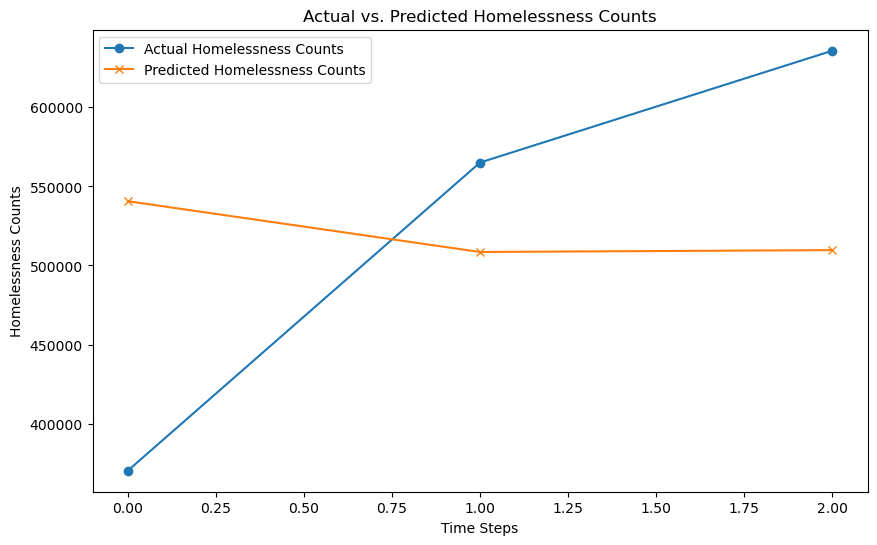

In [14]:
actual = y_test_inverse
predicted = predictions_inverse

plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Homelessness Counts', marker='o')
plt.plot(predicted, label='Predicted Homelessness Counts', marker='x')
plt.title('Actual vs. Predicted Homelessness Counts')
plt.xlabel('Time Steps')
plt.ylabel('Homelessness Counts')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_test_inverse, predictions_inverse)
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(y_test_inverse, predictions_inverse)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 117657.85416666667
Mean Squared Error (MSE): 16038700124.579428
Root Mean Squared Error (RMSE): 126643.98968991551
